In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score
from keras.utils import np_utils, plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14696688636086147556, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5248141170670441576
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6576138681510776921
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5707721525139782218
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp '/content/drive/My Drive/Colab Notebooks/pca_train_data.csv' /content/
!cp '/content/drive/My Drive/Colab Notebooks/select_train_meta.csv' /content/

In [5]:
# Loading the Data
data = pd.read_csv('/content/pca_train_data.csv', index_col=0)
metadata = pd.read_csv('/content/select_train_meta.csv', index_col=0)
targets = metadata['target']

data = np.expand_dims(data, axis=2)
n_samples, n_features, n_outputs = data.shape
print(n_samples, n_features, n_outputs)

2625 369 1


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(data, targets, test_size=0.2, random_state=42)
y_train = np_utils.to_categorical(np.array(y_train))
y_valid = np_utils.to_categorical(np.array(y_valid))

In [0]:
learning_rate = 0.0005
train_epochs=100
dropout = 0.35

In [0]:
def dense_model():
    # Define the network
    model = Sequential()
    model.add(Dense(2048, input_shape=(369, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=learning_rate),
                  metrics=['accuracy'])
    
    return model

In [9]:
model = dense_model()
plot_model(model, '/content/model_dense_pca.png', show_shapes=True)
model.summary()

W0904 17:08:36.234033 140471922685824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 17:08:36.240840 140471922685824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 17:08:36.252476 140471922685824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 17:08:36.379902 140471922685824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0904 17:08:36.409795 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 369, 2048)         4096      
_________________________________________________________________
batch_normalization_1 (Batch (None, 369, 2048)         8192      
_________________________________________________________________
activation_1 (Activation)    (None, 369, 2048)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 369, 2048)         0         
_________________________________________________________________
dense_2 (Dense)              (None, 369, 1024)         2098176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 369, 1024)         4096      
_________________________________________________________________
activation_2 (Activation)    (None, 369, 1024)        

In [10]:
checkpointer = ModelCheckpoint(filepath='/content/saved_weights_dense_pca.hdf5', 
                               verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
                           verbose=1, mode='auto')

model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
          epochs=train_epochs, batch_size=32, callbacks=[checkpointer, early_stop], verbose=1)


W0904 17:08:37.286995 140471922685824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2100 samples, validate on 525 samples
Epoch 1/100
2100/2100 [==============================] - 15s 7ms/step - loss: 0.4844 - acc: 0.7924 - val_loss: 0.4044 - val_acc: 0.7790

Epoch 00001: val_loss improved from inf to 0.40436, saving model to /content/saved_weights_dense_pca.hdf5
Epoch 2/100
2100/2100 [==============================] - 11s 5ms/step - loss: 0.3755 - acc: 0.7981 - val_loss: 0.3931 - val_acc: 0.8038

Epoch 00002: val_loss improved from 0.40436 to 0.39313, saving model to /content/saved_weights_dense_pca.hdf5
Epoch 3/100
2100/2100 [==============================] - 11s 5ms/step - loss: 0.3454 - acc: 0.8114 - val_loss: 0.4039 - val_acc: 0.8019

Epoch 00003: val_loss did not improve from 0.39313
Epoch 4/100
2100/2100 [==============================] - 11s 5ms/step - loss: 0.3343 - acc: 0.8219 - val_loss: 0.4069 - val_acc: 0.8000

Epoch 00004: val_loss did not improve from 0.39313
Epoch 5/100
2100/2100 [==============================] - 11s 5ms/step - loss: 0.3273 - 

In [0]:
model.load_weights('/content/saved_weights_dense_pca.hdf5')

In [0]:
valid_pred_real = model.predict(X_valid)
valid_pred = np_utils.to_categorical([np.argmax(prediction) for prediction in valid_pred_real])

In [13]:
score_acc = accuracy_score(y_valid, valid_pred)
score_f1 = f1_score(y_valid, valid_pred, average='macro')
score_prec = precision_score(y_valid, valid_pred, average='macro')
score_rec = recall_score(y_valid, valid_pred, average='macro')
score_mcc = matthews_corrcoef(y_valid.argmax(axis=1), valid_pred.argmax(axis=1))

print("accuracy for validation data is = {:.4f}".format(score_acc))
print("F1 score for validation data is = {:.4f}".format(score_f1))
print("precision for validation data is = {:.4f}".format(score_prec))
print("recall for validation data is = {:.4f}".format(score_rec))
print("MCC for validation data is = {:.4f}".format(score_mcc))

accuracy for validation data is = 0.8038
F1 score for validation data is = 0.5189
precision for validation data is = 0.7775
recall for validation data is = 0.5377
MCC for validation data is = 0.2045


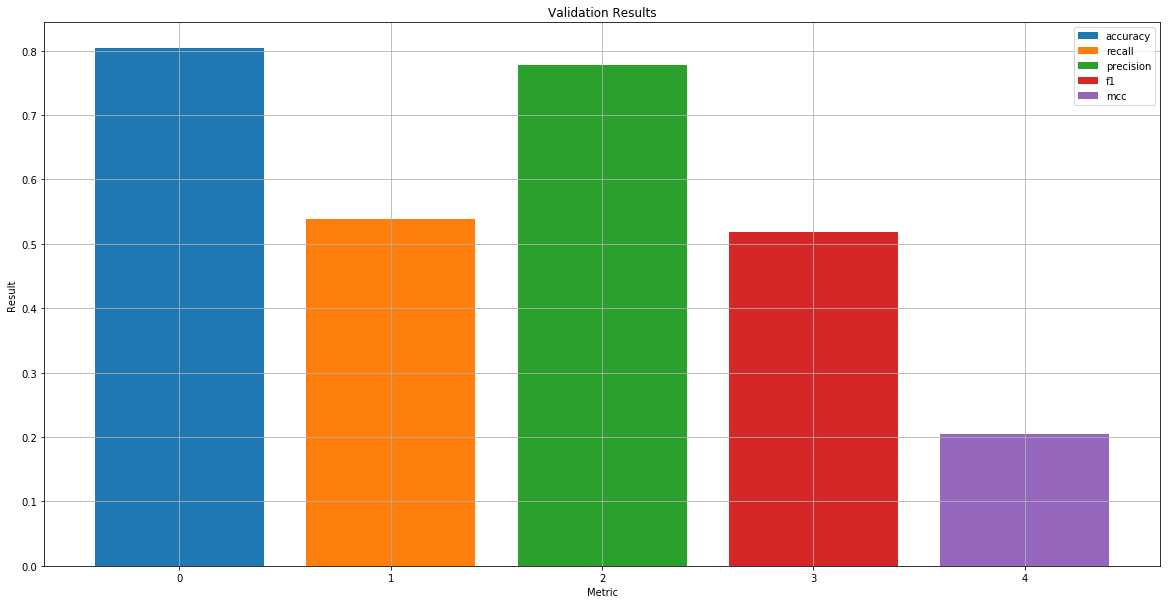

In [14]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.bar(0, score_acc)
ax1.bar(1, score_rec)
ax1.bar(2, score_prec)
ax1.bar(3, score_f1)
ax1.bar(4, score_mcc)
ax1.set(xlabel='Metric', ylabel='Result', title='Validation Results')
ax1.legend(['accuracy', 'recall', 'precision', 'f1', 'mcc'])
ax1.grid()
plt.show();

In [0]:
!rm '/content/pca_train_data.csv'
!rm '/content/select_train_meta.csv'

In [0]:
!cp '/content/saved_weights_dense_pca.hdf5' '/content/drive/My Drive/Colab Notebooks/'
!cp '/content/model_dense_pca.png' '/content/drive/My Drive/Colab Notebooks/'